# Churn At Telco


# Project Goals

- Discover drivers of churn at Telco
- Use drivers to develop a machine learning model that accurately predicts customer churn
- Churning is defined as a customer cutting ties with the service(s) Telco provides
- This information could be used to further our understanding of how customers at Telco (and simliar companies) think and help other companies better understand consumer behavior


## Imports

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# machine learning imports 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score
from pydataset import data
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# import premade functions
import prepare
import acquire
import modeling

#Removes big scary warnings
import warnings
warnings.filterwarnings('ignore')

## Acquire

* Data aquired from SQL telco_churn database
* It contained 7043 rows and 24 columns before cleaning
* Each row represents a customer
* Each column represents a feature associated of the customer


In [3]:
# Import acquired messy data
telco = acquire.get_telco_data()
# Lets take a quick peak
telco.head(1)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check


## Prepare

Prepare Actions:

- Removed columns that did not contain useful information (payment_type_id, internet_service_type_id, contract type_id etc.)
- Checked for nulls in the data and dropped null values stored as white space
- Checked that column data types were appropriate and had to change total_charges to from object to a float
- Converted binary categorical variables to numeric (yes/no & male/female)
- Added dummy variables for the non-binary categorical variables and then concatenated them to the original dataframe
- Split data into train, validate and test, stratifying on 'churn'

In [4]:
# Import prepare function to clean data 
telco = prepare.prep_telco(telco)
# Quick peak into the cleaned data
telco.head(1)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,contract_type,internet_service_type,churn_Yes,gender_Male,partner_Yes,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,One year,DSL,0,0,1,...,0,1,0,1,0,0,0,0,0,1


| Feature | Definition |
|:--------|:-----------|
|gender|Specifies if male or female|
|senior_citizen|True or False, specifies if senior citizen or not|
|partner|True or False, specifies if customer has partner or not|
|dependents|True or False, specifies if customer has partner or not|
|tenure|Integer, how many months the customer has been with Telco|
|phone_service|Yes or No, specifies if customer has phone service|
|multiple_lines|Yes or No, specifies if customer has multiple lines|
|online_security|Yes or No, specifies if customer has online security|
|online_backup|Yes or No, specifies if customer has online backup|
|device_protection|Yes or No, specifies if customer has device protection|
|tech_support|Yes or No, specifies if customer has tech support|
|streaming_tv|Yes or No, specifies if customer has streams tv|
|streaming_movies|Yes or No, specifies if customer streams movies|
|paperless_billing|Yes or No, specifies if customer has paperless billing|
|monthly_charges|Charges in a month, measured in dollars|
|total_charges|Total charges overal, measured in dollars|
|churn|The word used to define if a customer has left Telco|
|contract_type|Specifies contract type, month-to-month, two-year, one-year|
|payment_type|Specifies payment type, electronic check, mailed check, bank transfer, credit card|
|internet_service_type|Specifies internet service type, fiber optic, dsl, or none|

In [5]:
# splitting data into train, validate, and test
train, val, test = prepare.my_train_test_split(telco, 'churn_Yes')
# lets see the shape of these
train.shape, val.shape, test.shape

((4225, 30), (1409, 30), (1409, 30))

# Explore

## Are customers with Tech Support more or less likely to churn?

In [10]:
def get_tech(df):
    # using a countplot to give a visual 
    sns.set_theme(style="whitegrid")
    sns.countplot(data=train, x="churn_Yes", hue="tech_support_Yes")
    #labels and legend
    plt.title('Tech Support')
    plt.xlabel('Did They Churn?')
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('# of Customers')
    title = 'Tech Support'
    mylabels = ['No', 'Yes']
    plt.legend(title=title, labels=mylabels)
    plt.show()

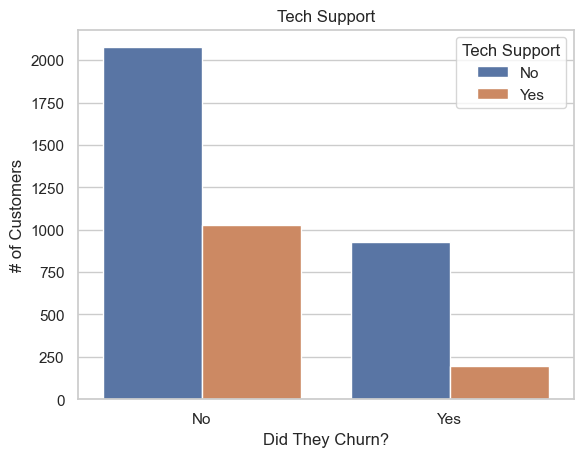

In [11]:
get_tech(telco)

#### My takeaway from this is that there appears to be a relationship between having tech support and churn.  The more Tech support, less likely the churn rate. 
  
  
##### For this question, there are two categorical variables at hand so a a chi-square test seems appropiate to determine if there is a relationship.

#### My H_o (Null Hypothesis): is that there is no significant relationship between churn and tech support

#### My H_a (Alternative Hypothesis): is that there is a relationship of significance.

In [13]:
def question_hypothesis_test1(df):
    # observed data for chi-square test
    observed1 = pd.crosstab(train.tech_support_Yes, train.churn_Yes)
    observed1
    # do not forget alpha
    alpha = .05

    chi2, p, degf, expected = stats.chi2_contingency(observed1)
    # clean f strings
    print(f"chi^2: {chi2}")
    print(f"p value: {p}")

In [15]:
question_hypothesis_test1(train)

chi^2: 98.23088931064383
p value: 3.7233642021021574e-23


#### My p-value is very small, so we reject our null hypothesis. We can say with confidence that there is sigificance in the relationship between churn and Tech Support. This makes an adequate driver to model.

## What contract type churns the most?

In [36]:
def get_contracts(df):
    # trusty count plot for visual
    sns.set_theme(style="whitegrid")
    sns.countplot(data=df, x="churn_Yes", hue="contract_type")
    #labels and legend
    plt.title('Churn Vs Types of Contracts')
    plt.xlabel('Churn')
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('# of Customers')
    title = 'Contract Type'
    plt.legend(title=title)
    plt.show()

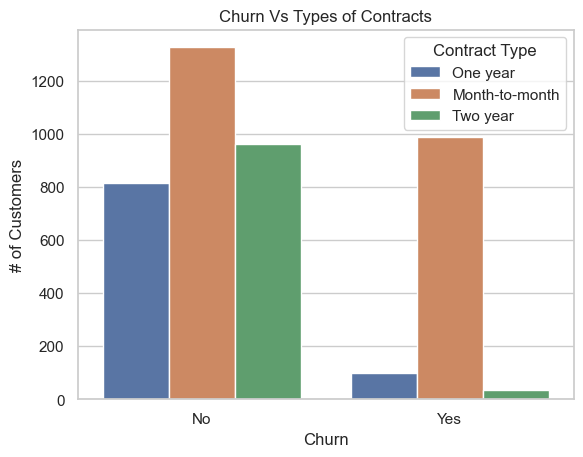

In [37]:
get_contracts(train)

#### My takeaway from this is (visually) there seems to be a big churn rate when a customer has a month-to-month contract versus other contracts. It is also the most popular contract type.

#### H_o (Null Hypothesis): contract type is independent of churn.

#### H_a (Alternative Hypothesis): contract is dependent on churn.

In [21]:
def question_hypothesis_test2(df):
    # observed data for chi-square test
    observed2 = pd.crosstab(df.contract_type, df.churn_Yes)
    observed2
    # do not forget alpha
    alpha = .05

    chi2, p, degf, expected = stats.chi2_contingency(observed2)
    # clean f strings
    print(f"chi^2: {chi2}")
    print(f"p value: {p}")

In [22]:
question_hypothesis_test2(train)

chi^2: 703.7870674341639
p value: 1.4947896745220748e-153


#### My p-value is very small, so we reject our null hypothesis. We can say with confidence that there is sigificance in the relationship between churn and contract type month-to-month. This makes another adequate driver to model.

## Does being a senior citizen have an affect on churn?

In [34]:
def get_seniors(df):
    sns.set_theme(style="whitegrid")
    sns.countplot(data=df, x="churn_Yes", hue="senior_citizen")
    #labels and legend
    plt.title('Churn Vs Senior Citizens')
    plt.xlabel('Churn')
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('# of Customers')
    title = 'Senior Citizen'
    mylabels = ['No', 'Yes']
    plt.legend(title=title, labels=mylabels)
    plt.show()

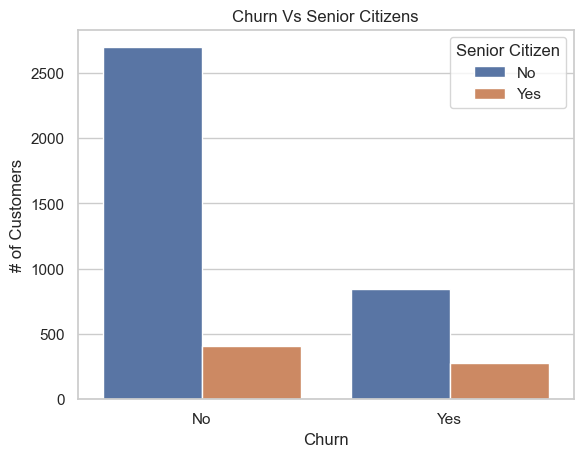

In [35]:
get_seniors(train)

#### My takeaway here is that the senior citizens churn at a lower rate than their younger counter parts. I think we will investigate the question of whether being a senior citizen is independent of churn with a chi-square test.

#### H_o (Null Hypothesis): senior citizen is independent of churn.

#### H_a (Alternative Hypothesis): senior citizen is dependent on churn.

In [28]:
def question_hypothesis_test3(df):
    # trusted chi-square test
    observed3 = pd.crosstab(df.senior_citizen, df.churn_Yes)
    observed3
    # do not forget alpha
    alpha = .05

    chi2, p, degf, expected = stats.chi2_contingency(observed3)
    # clean f strings
    print(f"chi^2: {chi2}")
    print(f"p value: {p}")

In [29]:
question_hypothesis_test3(train)

chi^2: 80.79361466512287
p value: 2.505662983276272e-19


#### My p-value is very small, so we reject our null hypothesis. We can say with confidence that there is sigificance in the relationship between churn and being a senior citizen. This could make a driver, but people cannot choose their age.

## Do customers who churn have paperless billing?

In [32]:
def get_paper(df):
    # count plot
    sns.set_theme(style="whitegrid")
    sns.countplot(data=df, x="churn_Yes", hue="paperless_billing_Yes")
    # title and legend
    plt.title('Churn Vs Paperless Billing')
    plt.xlabel('Churn')
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('# of Customers')
    title = 'Paperless Billing'
    mylabels = ['No', 'Yes']
    plt.legend(title=title, labels=mylabels)
    plt.show()

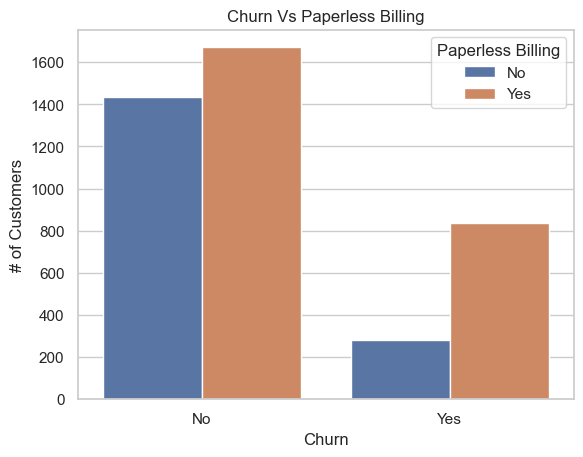

In [33]:
get_paper(train)

#### Initially, I thought paperless billing would churn at a lower rate but it appears the actual takeaway is paperless billing customer tend to churn more than one who prefer practice their handwriting.

#### H_o (Null Hypothesis): paperless billing is independent of churn.

#### H_a (Alternative Hypothesis): paperless is dependent on churn.

In [38]:
def question_hypothesis_test4(df):
    observed4 = pd.crosstab(df.paperless_billing_Yes, df.churn_Yes)
    observed4
    # do not forget alpha
    alpha = .05

    chi2, p, degf, expected = stats.chi2_contingency(observed4)
    # clean f strings
    print(f"chi^2: {chi2}")
    print(f"p value: {p}")

In [40]:
question_hypothesis_test4(train)

chi^2: 148.58446697144495
p value: 3.5348504574964642e-34


#### My p-value is very small, so we reject our null hypothesis. We can say with confidence that there is sigificance in the relationship between churn and having paperless billing. This makes another driver to model.

# Exploration Summary

- Tech Support was found to be a driver of churn
- Contract type month-to-month was found to be a big driver of churn
- Senior citizen status was found to have a relationship with churn, but I decided against using it as a driver as people cannot choose their age. 
- Paperless billing was found to be a driver of churn

# Modeling

- I ran the Decision Tree, Random Forest, KNN, and Logistic Regression algorithms to see what fit the data best .
- The evaluation metric used was accuracy, as I wanted to focus on accuracy over the other metrics.

- The basline accuracy is calculated by finding the outcome that occurs most frequent and create a column. You then divide the mean of the baseline column.


In [43]:
# code to generate baseline 
telco['baseline'] = telco['churn_Yes'].value_counts().idxmax()
(telco['churn_Yes'] == telco['baseline']).mean()
# clean f string
print(f"Baseline: {(telco['churn_Yes'] == telco['baseline']).mean()*100:.2f}%")

Baseline: 73.46%


In [45]:
def get_baseline(df):
    # code to generate baseline 
    df['baseline'] = df['churn_Yes'].value_counts().idxmax()
    (df['churn_Yes'] == df['baseline']).mean()
    # clean f string
    print(f"Baseline: {(df['churn_Yes'] == df['baseline']).mean()*100:.2f}%")

In [46]:
get_baseline(telco)

Baseline: 73.46%


In [43]:
def model_prep(df1,df2,df3):
    X_train = df1.drop(columns=['churn_Yes', 'contract_type', 'customer_id', 'internet_service_type'])
    y_train = df1.churn_Yes

    X_val = df2.drop(columns=['churn_Yes', 'contract_type', 'customer_id', 'internet_service_type'])
    y_val = df2.churn_Yes

    X_test = df3.drop(columns=['churn_Yes', 'contract_type', 'customer_id', 'internet_service_type'])
    y_test = df3.churn_Yes
    seed=42

    return X_train, X_val, X_test, y_train, y_val, y_test

In [44]:
X_train, X_val, X_test, y_train, y_val, y_test= model_prep(train,val,test)

# Random Forest - Model 1

In [51]:
# random forest algorithm 
rf3 = RandomForestClassifier(max_depth=8, random_state=42,
                            max_samples=0.5)
#fit it 
rf3.fit(X_train, y_train)
# clean f string
print('Random Forest Model')
print(f"Accuracy of Random Forest on train data: {rf3.score(X_train, y_train)}") 
print(f"Accuracy of Random Forest on validate: {rf3.score(X_val, y_val)}")

Random Forest Model
Accuracy of Random Forest on train data: 0.8333727810650887
Accuracy of Random Forest on validate: 0.8048261178140526


In [52]:
def get_forest(X_train, X_val, y_train, y_val):
    '''get random forest accuracy on train and validate data'''
    
    rf3 = RandomForestClassifier(max_depth=8, random_state=42,
                            max_samples=0.5)

    rf3.fit(X_train, y_train)
    print(f"Accuracy of Random Forest on train data: {rf3.score(X_train, y_train)}") 
    print(f"Accuracy of Random Froest on validate: {rf3.score(X_val, y_val)}")

In [53]:
get_forest(X_train, X_val, y_train, y_val)

Accuracy of Random Forest on train data: 0.8333727810650887
Accuracy of Random Froest on validate: 0.8048261178140526


# Logistic Regression - Model 2

In [18]:
# Logistic Regression algorithm
logit2 = LogisticRegression(C=.1, random_state=42, 
                           intercept_scaling=1, solver='lbfgs')

#fit the model
logit2.fit(X_train, y_train)
#clean f string
print('Logistic Regression Model')
print(f"Accuracy of Logistic Regression on train: {logit2.score(X_train, y_train)}") 
print(f"Accuracy of Logistic Regression on validate: {logit2.score(X_val, y_val)}")

Logistic Regression Model
Accuracy of Logistic Regression on train: 0.8009467455621302
Accuracy of Logistic Regression on validate: 0.8168914123491838


In [56]:
def get_reg(X_train, X_val, y_train, y_val):
    '''get logistic regression accuracy on train and validate data'''

    # create model object and fit it to the training data
    logit = LogisticRegression(C=.1, random_state=42, 
                               intercept_scaling=1, solver='lbfgs')
    # fit the model
    logit.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Logistic Regression on train is {logit.score(X_train, y_train)}")
    print(f"Accuracy of Logistic Regression on validate is {logit.score(X_val, y_val)}")

In [57]:
get_reg(X_train, X_val, y_train, y_val)

Accuracy of Logistic Regression on train is 0.8009467455621302
Accuracy of Logistic Regression on validate is 0.8168914123491838


# KNN - Model 3

In [62]:
# K nearest neighbor algorithm

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
knn3.score(X_train, y_train)
# clean f string
print('KNN Model')
print(f"Accuracy of KNN on train: {knn3.score(X_train, y_train)}") 
print(f"Accuracy of KNN on validate: {knn3.score(X_val, y_val)}")

KNN Model
Accuracy of KNN on train: 0.8565680473372781
Accuracy of KNN on validate: 0.7622427253371186


In [60]:
def get_knn(X_train, X_val, y_train, y_val):
    '''get KNN accuracy on train and validate data'''

    # create model object and fit it to the training data
    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
    knn.fit(X_train, y_train)

    # print results
    print(f"Accuracy of Logistic Regression on train is {knn.score(X_train, y_train)}")
    print(f"Accuracy of Logistic Regression on validate is {knn.score(X_val, y_val)}")

In [61]:
get_knn(X_train, X_val, y_train, y_val)

Accuracy of Logistic Regression on train is 0.831715976331361
Accuracy of Logistic Regression on validate is 0.7771469127040455


In [58]:
def get_dt(X_train, X_val, y_train, y_val):
    '''get decision tree accuracy on train and validate data'''

    # create classifier object
    clf3 = DecisionTreeClassifier(max_depth=8, random_state=42)

    #fit model on training data
    clf3 = clf3.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Decision Tree on train data is {clf3.score(X_train, y_train)}")
    print(f"Accuracy of Decision Tree on validate data is {clf3.score(X_val, y_val)}")

In [59]:
get_dt(X_train, X_val, y_train, y_val)

Accuracy of Decision Tree on train data is 0.8416568047337278
Accuracy of Decision Tree on validate data is 0.7970191625266146


In [76]:
def get_top_models(X_train, y_train, X_validate, y_validate):
    '''This function gets all the top ML models and plots them together for a visual'''

    # best Random Forest
    best_rf = RandomForestClassifier(max_depth=8, random_state=42,
                                    max_samples=0.5)
    best_rf.fit(X_train, y_train)

    best_rf_train_score = best_rf.score(X_train, y_train)
    best_rf_validate_score = best_rf.score(X_validate, y_validate)

    # Best KNN
    best_knn = KNeighborsClassifier(n_neighbors=3)
    best_knn.fit(X_train, y_train)

    best_knn_train_score = best_knn.score(X_train, y_train)
    best_knn_validate = best_knn.score(X_validate, y_validate)

    # Best Logistic Regression
    best_lr = LogisticRegression(C=.1, random_state=42, 
                                intercept_scaling=1, solver='lbfgs')
    best_lr.fit(X_train, y_train)

    best_lr_train_score = best_lr.score(X_train, y_train)
    best_lr_validate_score = best_lr.score(X_validate, y_validate)

    # Best Decision Tree
    best_clf = DecisionTreeClassifier(max_depth=8, random_state=42)  
    best_clf.fit(X_train, y_train)

    best_clf_train_score = best_clf.score(X_train, y_train)
    best_clf_validate_score = best_clf.score(X_validate, y_validate)

    # lists with model names & score information
    best_model_name_list = ["KNN","Random_Forest","Logistic_Regression","Decision Tree"]
    best_model_train_scores_list = [best_knn_train_score,best_rf_train_score,best_lr_train_score,best_clf_train_score]
    best_model_validate_scores_list = [best_knn_validate,best_rf_validate_score,best_lr_validate_score,best_clf_validate_score]
    
    # new empty DataFrame
    best_scores_df = pd.DataFrame()

    # new columns using lists for data
    best_scores_df["Model"] = best_model_name_list
    best_scores_df["Train_Score"] = best_model_train_scores_list
    best_scores_df["Validate_Score"] = best_model_validate_scores_list

    # plot it
    plt.figure(figsize=(11, 8.5))
    ax = best_scores_df.plot.bar(rot=5)
    baseline_accuracy = .7346
    plt.axhline(baseline_accuracy , label="Baseline Accuracy", color='red')
    plt.xticks(np.arange(4), ['KNN', 'Random Forest','Logistic Regression', 'Decision Tree'])
    plt.ylabel('Scores')
    plt.title('Top Models')
    sns.set_theme(style="whitegrid")
    ax.annotate('Best Model',fontsize=12,color="Black",weight="bold", xy=(1, 1), 
                xytext=(.65, .9))
    mylabels = ['Baseline','Train', 'Validate']
    ax.legend(labels=mylabels,bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0)
    plt.show()

<Figure size 1100x850 with 0 Axes>

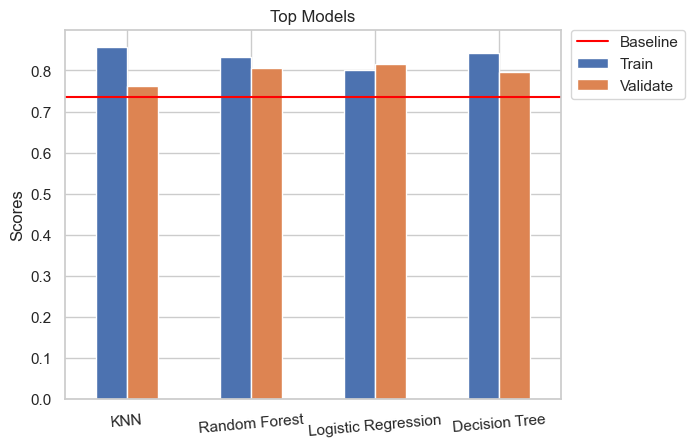

In [77]:
get_top_models(X_train, y_train, X_val, y_val)

### Test Model
* I am choosing the Logistic Regression as it has the highest accuracy.
* I will now run my model on the test data to gauge how it will perform on unseen data.

In [63]:
# # best Logistic Regression algorithm 

# test_score = logit2.score(X_test, y_test)

# # clean f string
# print('Random Forest Model')
# print(f'Accuracy on Test {test_score:.2f}')

def get_test(X_train, y_train, X_test, y_test):
    '''
    This function gets our best peforming model and runs it on our test data
    '''
    # random forest model was best
    logit2 = LogisticRegression(C=.1, random_state=42, 
                           intercept_scaling=1, solver='lbfgs')

    #fit the model
    logit2.fit(X_train, y_train)
    logit2.score(X_test,y_test)
    
     # clean f string
    display(Markdown(f'### Logistic Regression Model'))
    display(Markdown(f'### Accuracy on Test {logit2.score(X_test,y_test)*100:.2f}%'))

In [65]:
from IPython.display import display, Markdown
get_test(X_train, y_train, X_test, y_test)

### Logistic Regression Model

### Accuracy on Test 82.04%

### Modeling Wrap 

- Logistic Regression Test score outperforms the baseline and I would reccomend this model for production, as it beat the baseline by almost 8%


## Conclusion

### Summary
- Customers with tech support are less likely to churn

- The biggest driver of churn appears to be contract type. Customers who have month-to-month contracts churn at a rate just over 40%

- Paperless billing does not appear to have a big affect on churn rate.

- Age does not appear to have a significant affect on churn.

### Recommendations
- Creating a savings bundle (like some insurance companies) for customers who have multiple products can help incentivize using more services.
- Use Tech Support as a priority and differentiator for not only customer service, but for aquiring customer trust
- Give incentives to month-to-month contracts as it is the most popular contract type that churns. Incentives could include (for example) a temporarily free service such as Tech Support or if they were to go paperless with an app we could apply a discount while also collecting customer data to help with furture data science solutions.

### Next Steps  
* If provided more time to work on this project I would take a longer look at hyperparameters in my models to help optimize the accuracy and I would also take a dive into age and paperless billing and if there is a relationship.

In [79]:
rf_train_scores = []
rf_validate_scores = []
for i in range(1,20):
    loop_forest = RandomForestClassifier(max_depth=i, random_state=42, max_samples=0.5)
    loop_forest.fit(X_train, y_train)
    rf_train_scores.append(loop_forest.score(X_train, y_train))
    rf_validate_scores.append(loop_forest.score(X_val, y_val))
rf_scores = {'train':rf_train_scores,'validate':rf_validate_scores}
rf_scores = pd.DataFrame(rf_scores)
rf_scores

,train,validate
0,0.734675,0.734564
1,0.760473,0.760114
2,0.785325,0.783534
3,0.795503,0.799858
4,0.808284,0.802697
5,0.813254,0.804826
6,0.823432,0.804826
7,0.833373,0.804826
8,0.852781,0.807665
9,0.875503,0.803407


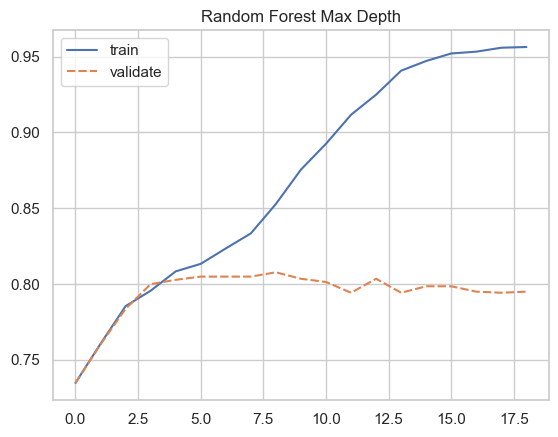

In [80]:
sns.lineplot(data = rf_scores)
plt.title("Random Forest Max Depth")
plt.show()

In [82]:
solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
c_values = [100, 10, 1.0, 0.1, 0.01]

lr_2_train_scores = []
lr_2_validate_scores = []
solver_list_names=[]
c_value_list=[]

for i in solver_list:
    for j in c_values:
        logit_loop_2 = LogisticRegression(C=j, random_state=42, 
                               intercept_scaling=1, solver=i)    
        logit_loop_2.fit(X_train, y_train)
        
        lr_2_train_scores.append(logit_loop_2.score(X_train, y_train))
        lr_2_validate_scores.append(logit_loop_2.score(X_val, y_val))
        solver_list_names.append(i)
        c_value_list.append(j)
lr_2_scores = {'train':lr_2_train_scores,'validate':lr_2_validate_scores,'solver_list':solver_list_names,'c_values':c_value_list}
lr_2_scores = pd.DataFrame(lr_2_scores)
lr_2_scores

,train,validate,solver_list,c_values
0,0.801420,0.814053,newton-cg,100.00
1,0.801420,0.813343,newton-cg,10.00
2,0.800237,0.814762,newton-cg,1.00
3,0.800947,0.814762,newton-cg,0.10
4,0.798817,0.806955,newton-cg,0.01
5,0.800710,0.815472,lbfgs,100.00
6,0.798817,0.809794,lbfgs,10.00
7,0.795503,0.803407,lbfgs,1.00
8,0.800947,0.816891,lbfgs,0.10
9,0.801420,0.809084,lbfgs,0.01


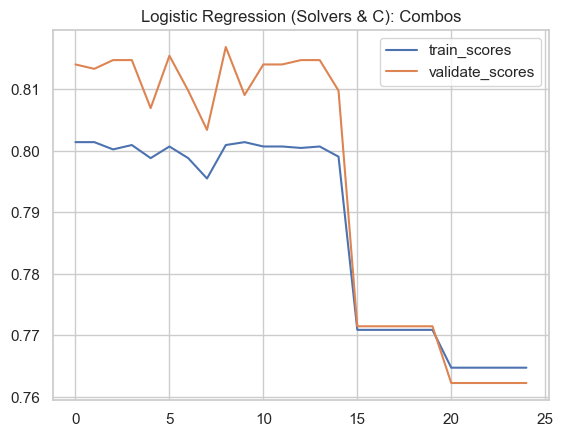

In [85]:
plt.plot(lr_2_scores["train"],label='train_scores')
plt.plot(lr_2_scores["validate"],label='validate_scores')
plt.legend()
plt.title("Logistic Regression (Solvers & C): Combos")
plt.show()

In [89]:
knn_train_scores = []
knn_validate_scores = []
for i in range(1,16):
    knn_loop = KNeighborsClassifier(n_neighbors=i)
    knn_loop.fit(X_train, y_train)
    knn_train_scores.append(knn_loop.score(X_train, y_train))
    knn_validate_scores.append(knn_loop.score(X_val, y_val))
knn_scores = {'train':knn_train_scores,'validate':knn_validate_scores}
knn_scores = pd.DataFrame(knn_scores)
knn_scores

,train,validate
0,0.998107,0.703336
1,0.856095,0.753726
2,0.856568,0.762243
3,0.830533,0.767211
4,0.831716,0.777147
5,0.817988,0.778566
6,0.817515,0.780696
7,0.812308,0.780696
8,0.811598,0.784954
9,0.807101,0.779986


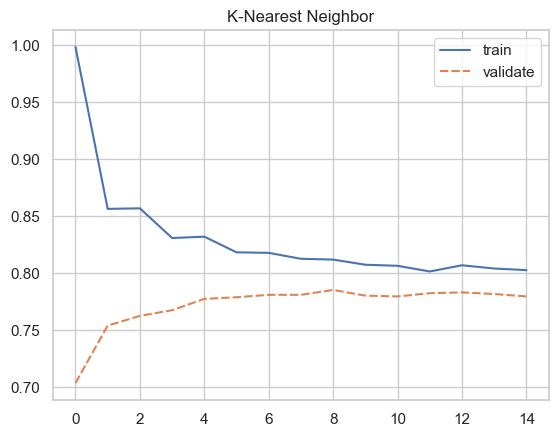

In [90]:
sns.lineplot(data=knn_scores)
plt.title("K-Nearest Neighbor")
plt.show()

In [93]:
clf_train_scores = []
clf_validate_scores = []
for i in range(1,14):
    clf_loop = DecisionTreeClassifier(max_depth=i)
    clf_loop.fit(X_train, y_train)
    clf_train_scores.append(clf_loop.score(X_train, y_train))
    clf_validate_scores.append(clf_loop.score(X_val, y_val))
clf_scores = {'train':clf_train_scores,'validate':clf_validate_scores}
clf_scores = pd.DataFrame(clf_scores)
clf_scores

,train,validate
0,0.734675,0.734564
1,0.759763,0.767211
2,0.787929,0.792761
3,0.792899,0.799148
4,0.801183,0.797019
5,0.814201,0.798439
6,0.823905,0.794890
7,0.840947,0.798439
8,0.857988,0.770759
9,0.879290,0.755145


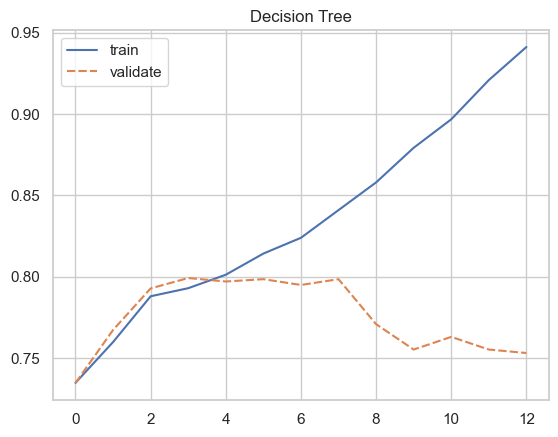

In [94]:
sns.lineplot(data=clf_scores)
plt.title("Decision Tree")
plt.show()

In [99]:
def get_mvb(X_train, y_train, X_test, y_test, df):
    '''This function plots the test data and plot the baseline together for a final visual'''
    
    # Recalculating Best Peforming Model with new name
    best_model = RandomForestClassifier(max_depth=8, random_state=42,
                            max_samples=0.5) 
    best_model.fit(X_train, y_train)
    best_model.score(X_test,y_test)
    
    # Baseline
    df['baseline'] = df['churn_Yes'].value_counts().idxmax()
    plot_baseline = (df['churn_Yes'] == df['baseline']).mean()
    
    # Best Performing Model(Logistic Regression Combo{c=100,newton-cg}) Test Score: 
    best_test_score = best_model.score(X_test,y_test)  
    
    # Test Scores: Project Baseline vs Best Model
    plot_baseline, best_test_score
    
    # Temporary Dictionary Holding Baseline & Model Test Score
    best_model_plot={"Baseline":[plot_baseline], "Test":[best_test_score]}
    
    # Converting Temporary Dictionary to DataFrame
    best_model_plot = pd.DataFrame(best_model_plot)
    
    # Visualizing Both Baseline & Model Test Scores
    fig=sns.barplot(data= best_model_plot,palette="colorblind")
    plt.title("Baseline vs. Best Model")
    fig.set(ylabel='Scores')
    plt.show()

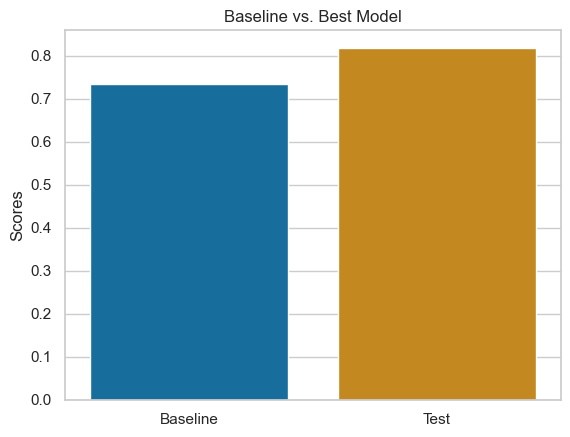

In [100]:
get_mvb(X_train, y_train, X_test, y_test, train)